# Self-Driving Car Engineer Nanodegree
## Project 3: (Deep Learning) Build a Traffic Sign Recognition Classifier

In this project, I used what I've learned about deep neural networks and convolutional neural networks to classify traffic signs. I trained and validate a model so it can classify traffic sign images using the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). After the model is trained.

In [1]:
# Load and import dependencies 
import numpy as np
import pickle
import glob
import csv
import cv2

from sklearn.utils import shuffle

from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [2]:
def duplicates(lst, item):    
    """ returns a list with indexes where element 'item' is repeated in list 'lst'
    Args:
        lst: `list` list to look for repeated elements  
        item: `undefined` elements to look indexes where is repeated in list 'lst'
    Returns: list with indexes where the element is repeated in input list
    """
    return [i for i, x in enumerate(lst) if x == item]


def plot_dataset(means_training, means_validation, means_test):

    """ plots dataset data distribution
    Args:
        means_training: `list` list with the amount of training samples for each class 
        means_validation: `list` list with the amount of validation samples for each class
        means_test: `list` list with the amount of testing samples for each class
    Returns:
    """
    
    # Plot parameters
    plt.rcParams["figure.figsize"] = (20,5)
    fig, ax = plt.subplots()
    index = np.arange(n_classes)
    bar_width = 0.2

    # Plot training, validation and test datasets
    rects1 = ax.bar(index, means_training, bar_width, alpha=0.4, color='b', label='Training')
    rects2 = ax.bar(index + bar_width, means_validation, bar_width, alpha=0.4, color='r', label='Validation')
    rects3 = ax.bar(index + 2*bar_width, means_test, bar_width, alpha=0.4, color='g', label='Test')

    # Plotting the graph
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Samples')
    ax.set_title('Dataset Description')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(map(str, range(n_classes + 1)))
    ax.legend()
    fig.tight_layout()
    plt.savefig('writeup_files/dataset_description_3.png')
    plt.show()



---

## Step 1: Dataset Loading, Summary and Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

In [3]:
# set where the training and testing data are saved
validation_file = "traffic-signs-data/valid.p"
training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

# Read each file
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
# Get features and labels
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


In [4]:
# Shuffle all datasets
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)


### Basic Summary of the Data Set

In [5]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# Total number of samples in dataset
n_total = n_test + n_validation + n_train

# Shape of an traffic sign image
image_shape = X_train.shape[1:]


# Get from csv file number of clases and descriptions
classes_dics = []
with open('traffic-signs-data/signnames.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for idx, row in enumerate(csv_reader):
        if idx > 0:
            
            train_idx = duplicates(list(y_train), int(row[0]))
            valid_idx = duplicates(list(y_valid), int(row[0]))
            test_idx = duplicates(list(y_test), int(row[0]))
            
            classes_dics.append({
                "id": int(row[0]), 
                "description": row[1], 
                "train": len(train_idx), 
                "vali": len(valid_idx), 
                "test": len(test_idx), 
                "train_idx": train_idx, 
                "vali_idx": valid_idx,
                "test_idx": test_idx
            })

# Unique classes/labels in the dataset.
n_classes = len(classes_dics)
            
print("-"*57)
print("| id\t| train\t\t| validation\t| testing\t|")
print("-"*57)
for dic in classes_dics:
    print("| {}\t| {:.2f}% - {}\t| {:.2f}% - {}\t| {:.2f}% - {}\t|  {}".format(
        dic["id"], 
        dic["train"]/n_train*100, dic["train"], 
        dic["vali"]/n_validation*100, dic["vali"], 
        dic["test"]/n_test*100, dic["test"], 
        dic["description"][0:30]))
print("-"*57,"\n")    
    
print("{:.2f}% - Number of training examples \t= {}".format(n_train/n_total*100, n_train))
print("{:.2f}% - Number of validation examples \t= {}".format(n_validation/n_total*100, n_validation))
print("{:.2f}% - Number of testing examples \t= {}".format(n_test/n_total*100, n_test))

print("\nImage data shape =", image_shape)
print("Number of classes =", n_classes)


---------------------------------------------------------
| id	| train		| validation	| testing	|
---------------------------------------------------------
| 0	| 0.52% - 180	| 0.68% - 30	| 0.48% - 60	|  Speed limit (20km/h)
| 1	| 5.69% - 1980	| 5.44% - 240	| 5.70% - 720	|  Speed limit (30km/h)
| 2	| 5.78% - 2010	| 5.44% - 240	| 5.94% - 750	|  Speed limit (50km/h)
| 3	| 3.62% - 1260	| 3.40% - 150	| 3.56% - 450	|  Speed limit (60km/h)
| 4	| 5.09% - 1770	| 4.76% - 210	| 5.23% - 660	|  Speed limit (70km/h)
| 5	| 4.74% - 1650	| 4.76% - 210	| 4.99% - 630	|  Speed limit (80km/h)
| 6	| 1.03% - 360	| 1.36% - 60	| 1.19% - 150	|  End of speed limit (80km/h)
| 7	| 3.71% - 1290	| 3.40% - 150	| 3.56% - 450	|  Speed limit (100km/h)
| 8	| 3.62% - 1260	| 3.40% - 150	| 3.56% - 450	|  Speed limit (120km/h)
| 9	| 3.79% - 1320	| 3.40% - 150	| 3.80% - 480	|  No passing
| 10	| 5.17% - 1800	| 4.76% - 210	| 5.23% - 660	|  No passing for vehicles over 3
| 11	| 3.36% - 1170	| 3.40% - 150	| 3.33% - 420	|  Right-of

### Exploratory visualization of the dataset

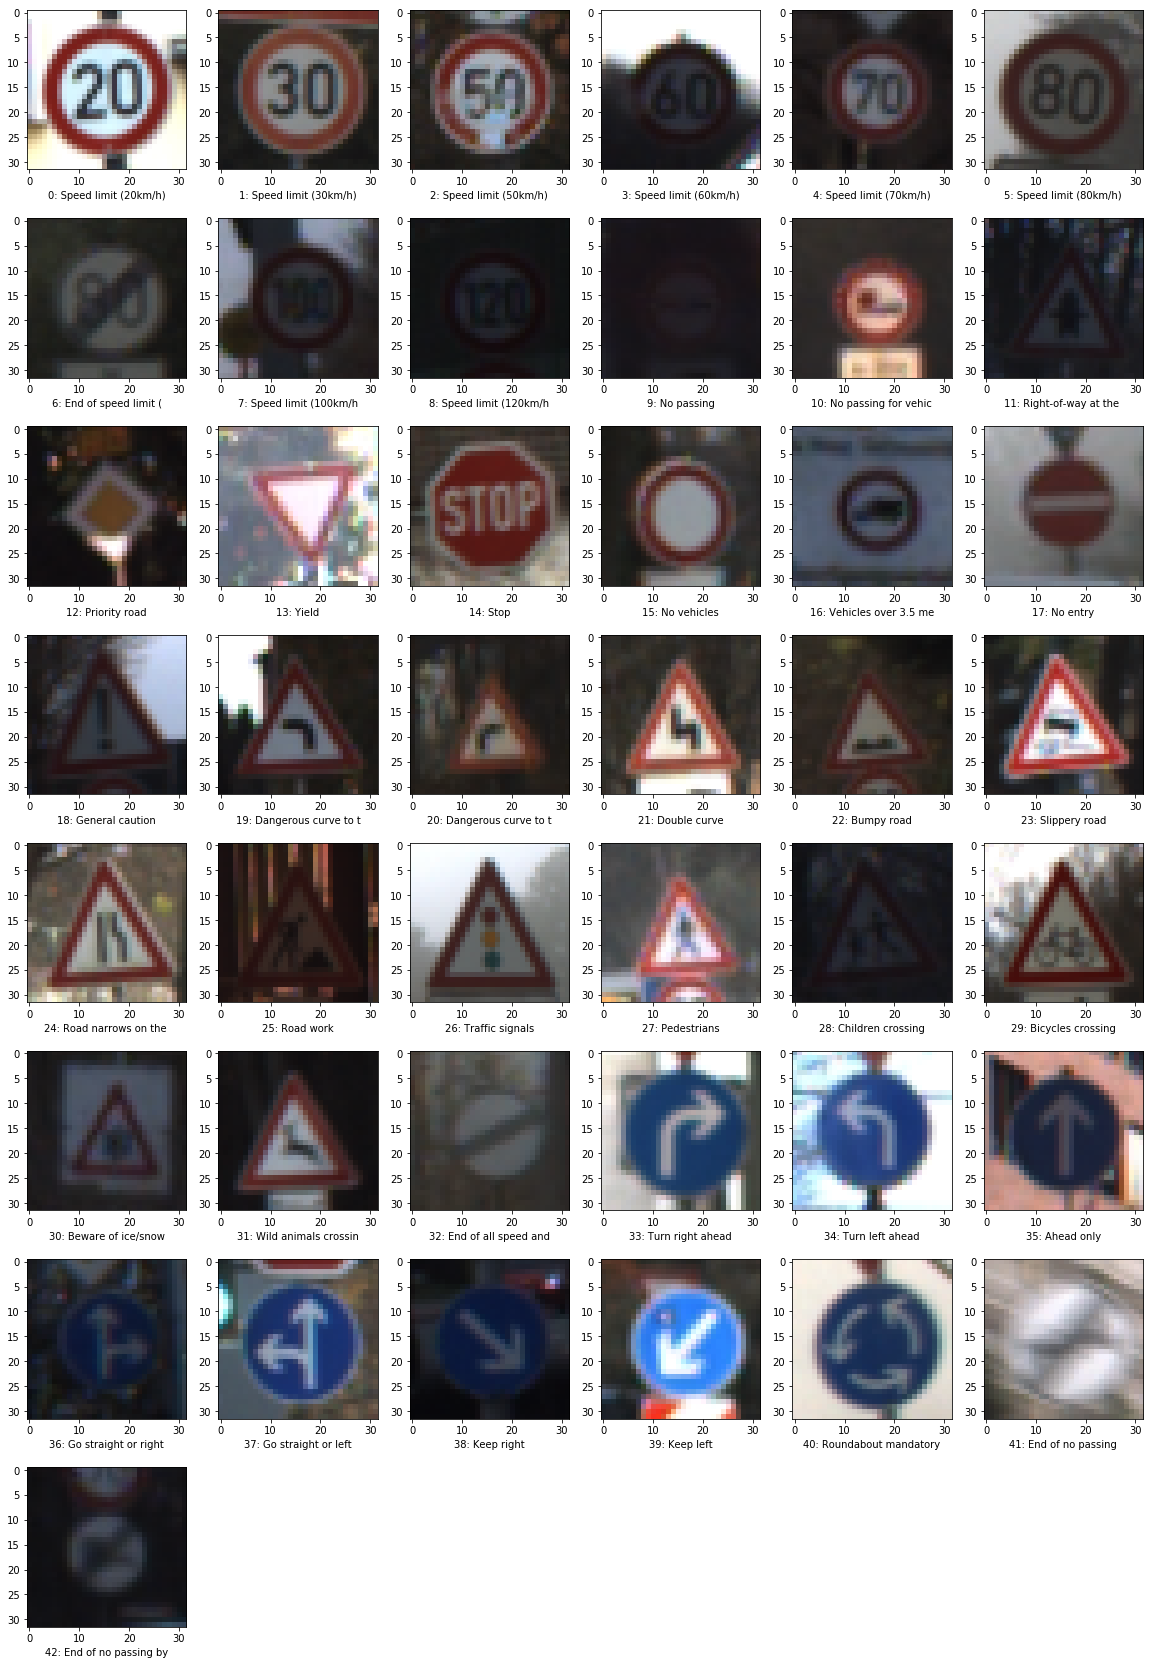

In [6]:
# Plot a random sample for each class
plt.figure(figsize=(20,30))
columns = 6
for idx in range(0, n_classes):
    len_idx = len(classes_dics[idx]["train_idx"])
    idx_data = classes_dics[idx]["train_idx"][np.random.randint(len_idx)]
    ax = plt.subplot(np.ceil(n_classes/columns), columns, idx + 1)
    plt.imshow(X_train[idx_data])
    ax.set_xlabel(str(idx)+": "+classes_dics[idx]["description"][0:20])
plt.savefig('writeup_files/dataset_description_2.png')
plt.show()


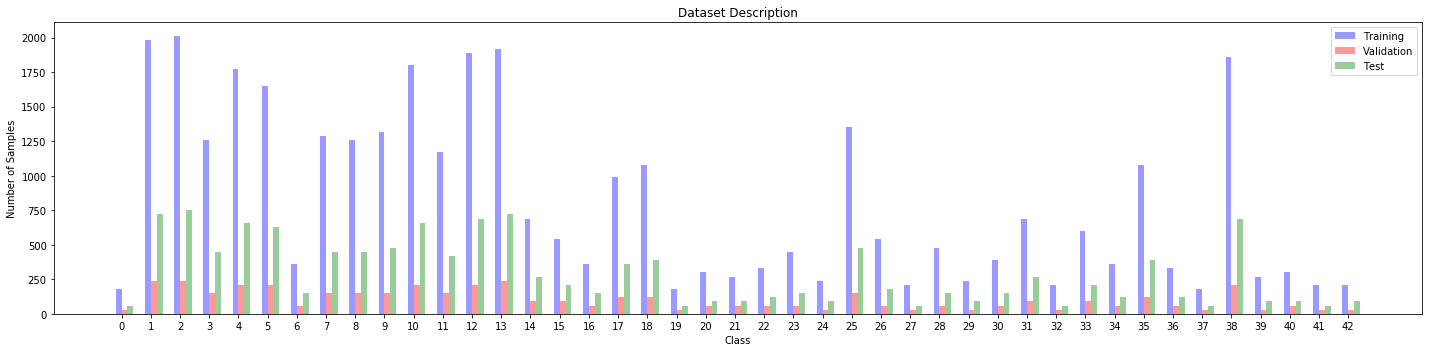

In [7]:
# Get the total of samples for each class for validation, training and test data sets
means_validation = [d['vali'] for d in classes_dics if 'vali' in d]
means_training = [d['train'] for d in classes_dics if 'train' in d]
means_test = [d['test'] for d in classes_dics if 'test' in d]
plot_dataset(means_training, means_validation, means_test)


### Data Augmentation:  Data Set Pre-processing

In [8]:
# 1 - Normalization and Gray scaling
def norm_and_gray(data):
    
    """Given 4D images (number, heigh, weight, channel), this
    function grayscales and returns (number, height, weight, 1) images"""
    
    def gray(src):
        if src.dtype == np.uint8:
            src = np.array(src/255.0, dtype=np.float32)
        dst = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
        return dst.reshape(32,32,1)
    norms = [gray(img) for img in data]
    return np.array(norms)

# 4 - Applying Distortion
def add_noisy(image, *argv):
    
    row,col,ch= image.shape
    mean = argv[0]
    var = argv[1]
    sigma = var**argv[2]
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return np.clip(noisy.astype('int'), a_min = 0, a_max = 255) 

# 3 - Rotating and Perspective Transformation
def rot_pers_transform():
    pass


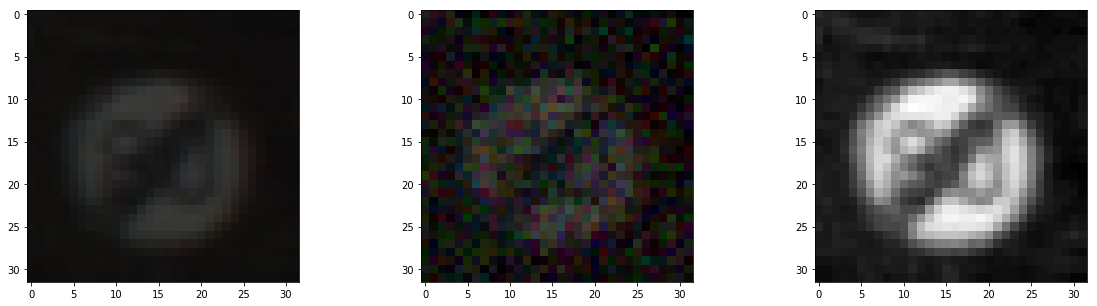

In [9]:
sample_noise = add_noisy(X_valid[0], 2, 200, 0.5)
X_valid_gray = norm_and_gray(X_valid)


_, vframes = plt.subplots(nrows=1, ncols=3)
vframes[0].imshow(X_valid[0])
vframes[1].imshow(sample_noise)
vframes[2].imshow(X_valid_gray[0].squeeze(), cmap='gray')


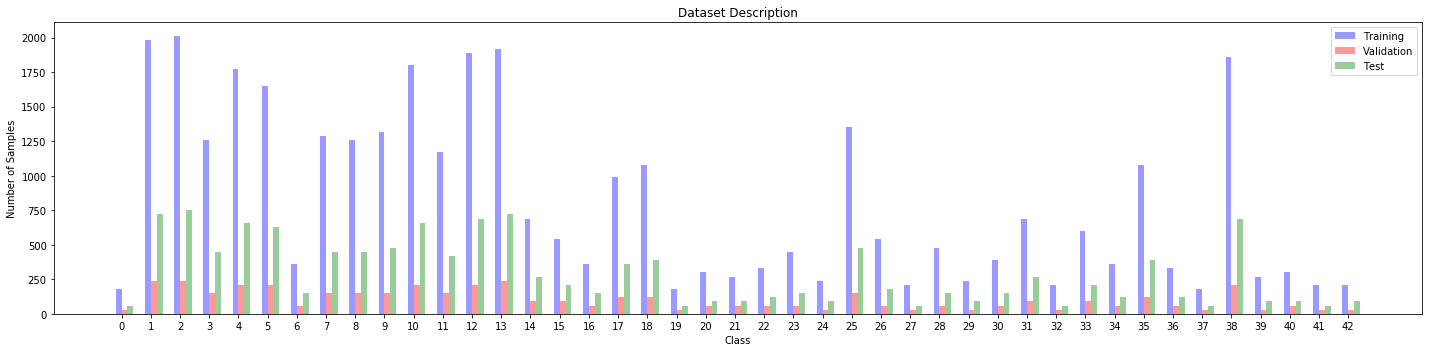

In [10]:
# Get the total of samples for each class for validation, training and test data sets
means_validation = [d['vali'] for d in classes_dics if 'vali' in d]
means_training = [d['train'] for d in classes_dics if 'train' in d]
means_test = [d['test'] for d in classes_dics if 'test' in d]
plot_dataset(means_training, means_validation, means_test)


----

## Step 2: Designing and Testing a Model Architecture

Next the designing and implementation of a deep learning model that learns to recognize traffic signs. Model was trained and tested with the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). The Network is inspired in the LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) and the lecture [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

There are various aspects were considered in this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.


### Model Architecture

In [1]:

import sys
sys.executable

# Load and import dependencies for model
import tensorflow as tf
from tensorflow.contrib.layers import flatten


ImportError: No module named 'tensorflow'

In [13]:
EPOCHS = 10
BATCH_SIZE = 128

In [79]:
def Clasifier(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases 
    # for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


---

## Step 3: Test a Model on New Images

To give more insight into how the model is working, more data was randomly downloaded from the web and used in the model to predict the traffic sign type.


### Loading New Data sets

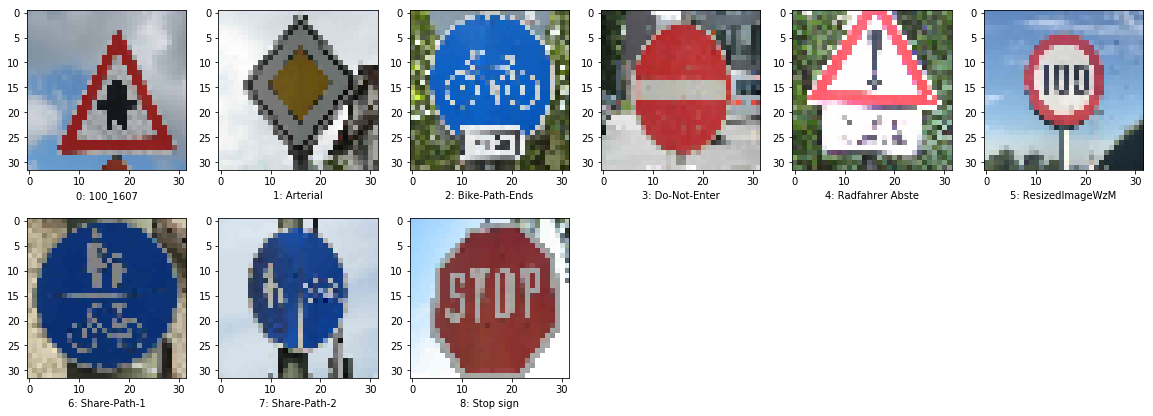

In [80]:
path = "traffic-signs-data/other_signs"
extensions = ["jpg","gif","png","tga"]

# Load images in 'path'
image_path_list = [item for i in [glob.glob(path+'/*.%s' % ext) for ext in extensions] for item in i]
image_list = np.asarray([cv2.cvtColor(cv2.resize(cv2.imread(img_path), image_shape[:2]), cv2.COLOR_BGR2RGB) \
              for idx, img_path in enumerate(image_path_list)])

# Visualize new dataset
plt.figure(figsize=(20,30)); columns = 6
for idx in range(0, len(image_list) if len(image_list) <= 12 else 12):
    ax = plt.subplot(np.ceil(n_classes/columns), columns, idx + 1)
    plt.imshow(image_list[idx])
    ax.set_xlabel(str(idx)+": "+image_path_list[idx].split("/")[-1].split(".")[0][0:15])
plt.savefig('writeup_files/new_data_set.png')
plt.show()
